<a href="https://colab.research.google.com/github/nmamie/ML4H_Project1/blob/master/ML4H_Project1_Task1_Nici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Heart Disease Prediction**

## Preparation

In [2]:
## basic packages
import pandas as pd
import numpy as np
import math
from IPython.display import display

In [3]:
## setup
import warnings
warnings.filterwarnings("ignore")

path = "/content/drive/MyDrive/1) ETH/3) ML in Healthcare/5) Assignments/Project 1/Data Heart Failure/"

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## data import
train_data = pd.read_csv(path + "train_val_split.csv")
test_data = pd.read_csv(path + "test_split.csv")

## **Q1: Exploratory Data Analysis**

### Basic checks

In [ ]:
## examine head
train_data.head()

In [ ]:
## check dataset sample size & dimensionality
n = len(train_data)
p = len(train_data.columns) - 1
print("No. of samples:  ", n)
print("No. of features: ", p)

In [ ]:
## check for missing data
missing_values=train_data.isnull().sum()

In [ ]:
# Export to latex
missing_values.to_latex("tables/missing_values.txt")

**Conclusions:**
*   We have significantly more observations than variables. Hence, no further problems arise.
*   There are no missing values.

**Implications:**
*   None

### Data types and distributions of variables

In [ ]:
## explore feature data types
train_data.dtypes

*FastingBS* and *HeartDisease* are binary, hence change to data type "object" for plotting.

In [6]:
## change data type of categorical variables to "object"
train_data["FastingBS"] = train_data["FastingBS"].astype("object")
train_data["HeartDisease"] = train_data["HeartDisease"].astype("object")

In [7]:
# save variable & names
var_names = train_data.columns.tolist()
fts_names = train_data.drop("HeartDisease", axis=1).columns.tolist()
num_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(exclude="object").columns.tolist()
cat_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(include="object").columns.tolist()
num_vars = train_data.select_dtypes(include="int64").columns.tolist()
cat_vars = train_data.select_dtypes(include="object").columns.tolist()

In [ ]:
# summary statistics
num_summary = train_data[num_fts].describe().round(2)
cat_summary = train_data[cat_fts].describe()
display(num_summary)
display(cat_summary)

In [ ]:
# Export to latex
num_summary.to_latex("tables/num_summary.txt")
cat_summary.to_latex("tables/cat_summary.txt")

<Axes: xlabel='HeartDisease', ylabel='count'>

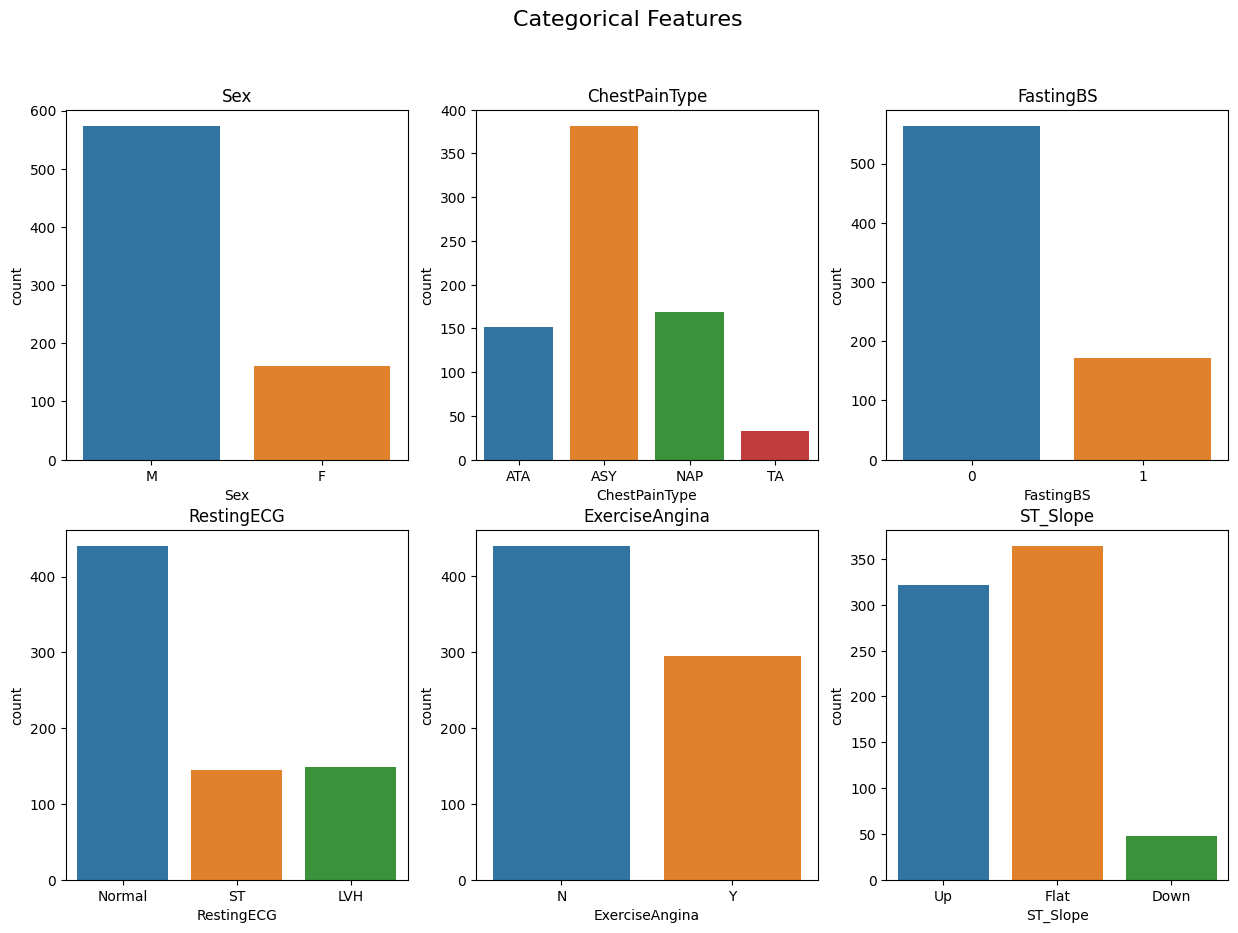

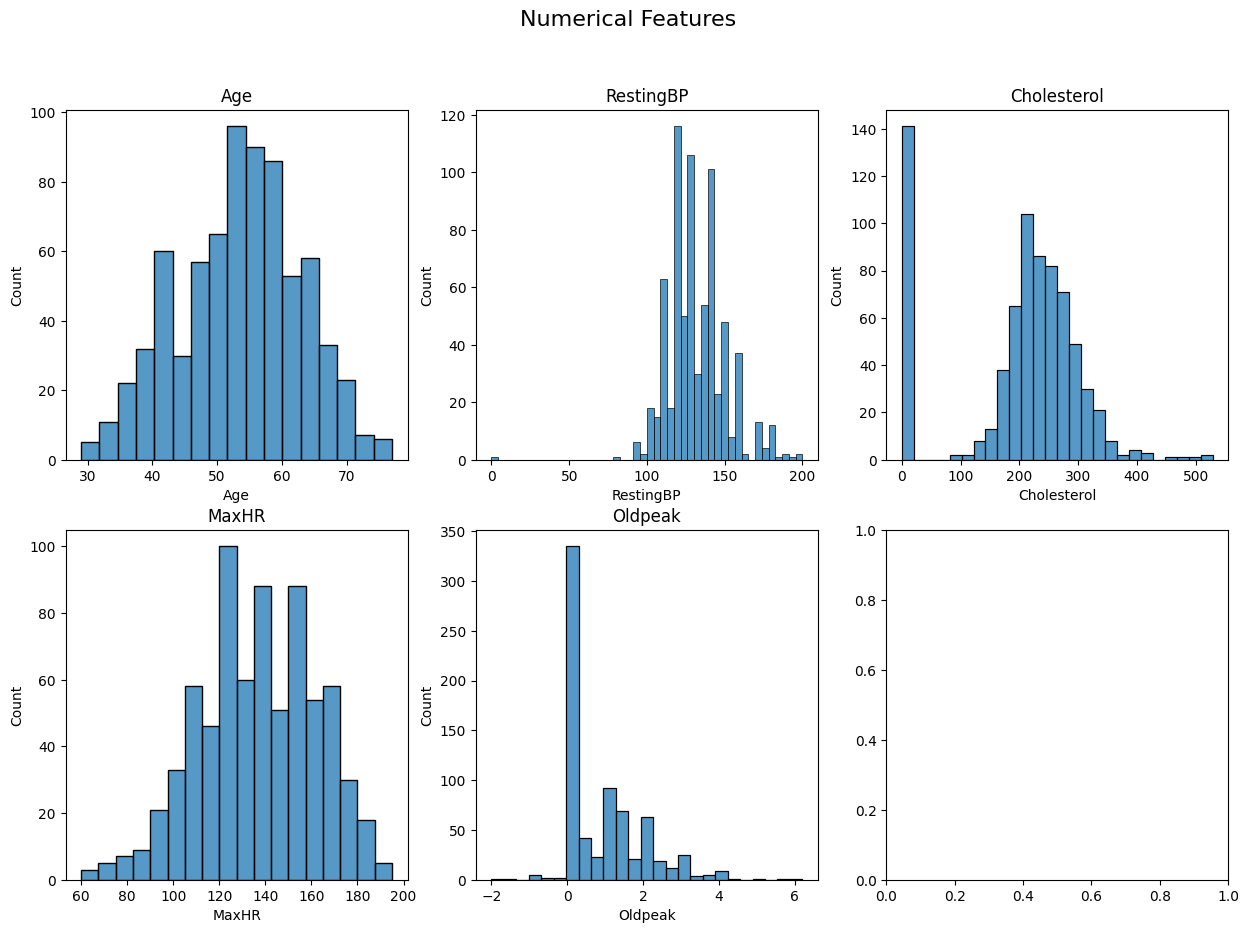

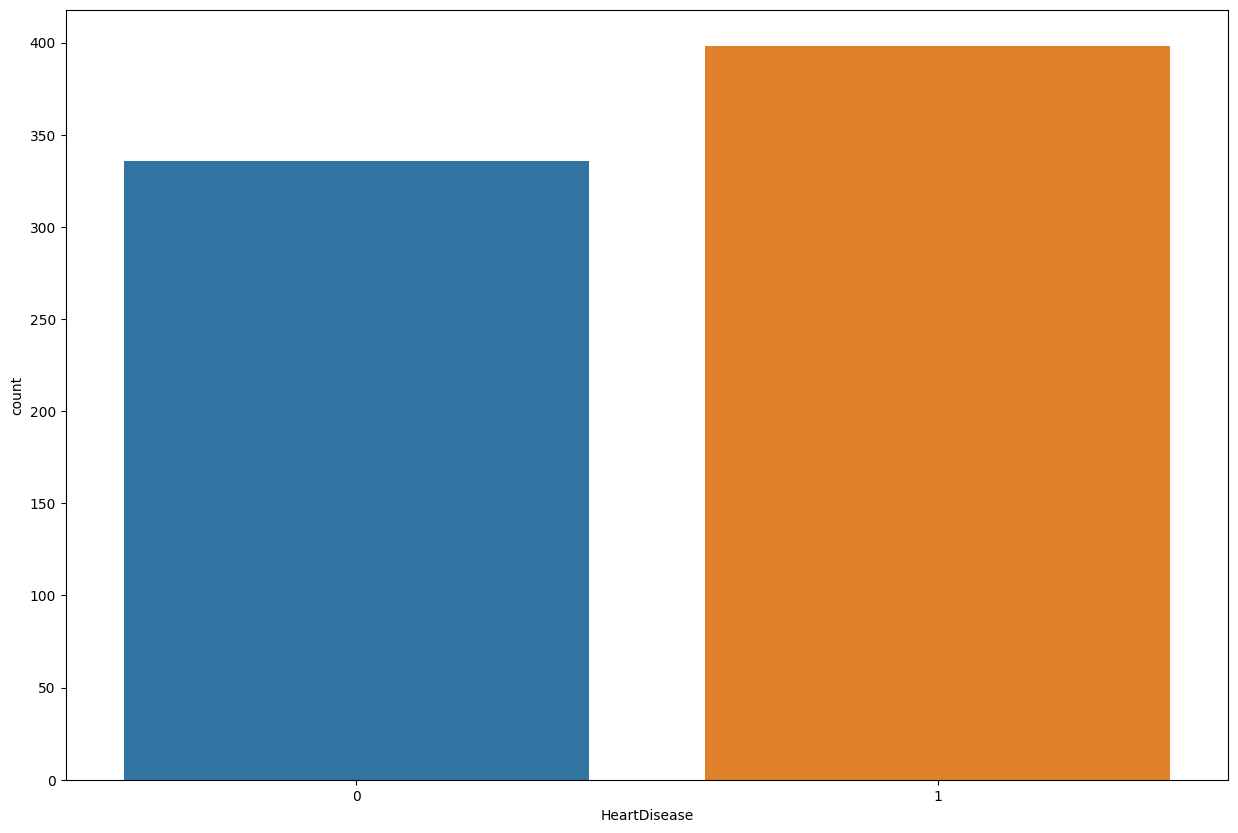

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

# categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=col, data=train_data, ax=ax)

# numerical features
fig, axs = plt.subplots(2, math.ceil(len(num_fts)/2), figsize=(15, 10))
fig.suptitle('Numerical Features', fontsize=16)
for i, col in enumerate(num_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.histplot(x=col, data=train_data, ax=ax)

# HeartDisease Plot
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
ax = axs
sns.countplot(x="HeartDisease", data=train_data, ax=ax)

In [ ]:
print("0s in RestingBP:")
print(" - Train Data: ", (train_data["RestingBP"] == 0).sum())
print(" - Test Data:  ", (test_data["RestingBP"] == 0).sum())

print("")
print("0s in RestingBP:")
print(" - Train Data: ", (train_data["Cholesterol"] == 0).sum())
print(" - Test Data:  ", (test_data["Cholesterol"] == 0).sum())

**Conclusions:**

1.   Some features are categorical, i.e. lack interpretability of differences in or ordering of their values.
2.   The dataset is imbalanced w.r.t. a couple of features, incl. *sex*, *chest pain type*, and *fasting blood sugar*. Importantly, however, the dataset is balanced w.r.t. the outcome variable, *heart disease*.
3.   *Cholesterol:* Many values of are exactly 0. Since virtually all values above 0 are >100, this seems highly unrealistic. Instead, we interpret this as missing values.
4.   *RestingBP:* There exist an observation with resting blood pressure of 0, which seems equally unrealistic. 

**Implications:**

1.   Create dummy variables or use one-hot encoding for the respective features.
2.  ...
3.   Since there are many observations with this anomaly, create a dummy variable indicating whether a patient's cholesterol measurement is missing or not.
4.   Since there is only 1 observation with this anomaly, ...

## EDA Preprocessing

For the purpose of EDA, our preprocessing pipeline consists of the following steps:

1.   Create dummy variable for *Cholesterol = 0*
2.   Mark *Cholesterol* as *NA* whenever it is 0
2.   Create dummy variables for categories

The corresponding dataset is called "train_proc_1"/"test_proc_1"

In [9]:
## add dummy for cholesterol=0
train_data["Cholesterol"].replace(0, np.nan, inplace=True)
test_data["Cholesterol"].replace(0, np.nan, inplace=True)

train_data.insert(loc=5, column="Chol_NA", value=train_data["Cholesterol"].isna()*1)
test_data.insert(loc=5, column="Chol_NA", value=test_data["Cholesterol"].isna()*1)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop=None))])

# preprocessor
preprocessing = ColumnTransformer(transformers = [("pass", "passthrough", ["HeartDisease", "Chol_NA"] + num_fts),
                                                  ("drop", "drop", fts_names),
                                                  ("cat", cat_transformer, cat_fts)],
                                  remainder = "passthrough")

In [11]:
## apply preprocessing pipeline to data
train_proc_1 = preprocessing.fit_transform(train_data)
test_proc_1 = preprocessing.fit_transform(test_data)

var_names = preprocessing.get_feature_names_out().tolist()
var_names = [var_names[i].replace("pass__", "").replace("num__", "").replace("cat__", "") for i in range(len(var_names))]
ft_names = var_names.copy()
ft_names.remove("HeartDisease")

train_proc_1 = pd.DataFrame(train_proc_1, columns=var_names)
test_proc_1 = pd.DataFrame(test_proc_1, columns=var_names)

In [12]:
## set numerical features to float, categorical to int
train_proc_1[num_fts] = train_proc_1[num_fts].astype("float64")
test_proc_1[num_fts] = test_proc_1[num_fts].astype("float64")

train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)] = train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)].astype("int64")
test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)] = test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)].astype("int64")

## Dependencies

Following intermediate data processing for exploratory data analysis only:

In [ ]:
## 

# HeartDisease & categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=train_data[col], data=train_proc_1, ax=ax, hue="HeartDisease")

# HeartDisease & continuous features
figure = plt.figure(figsize=(20,10))
figure.suptitle('Continuous Features', fontsize=16)
sns.pairplot(train_data[num_fts + ["HeartDisease"]], hue='HeartDisease', palette='Blues')

In [ ]:
## define default variables and drop their dummy

default_vars = ["Sex_M",
                "ChestPainType_ASY",
                "FastingBS_0",
                "RestingECG_Normal",
                "ExerciseAngina_N",
                "ST_Slope_Flat"]

train_eda = train_proc_1.drop(default_vars, axis=1, inplace=False)

To examine dependencies, we remove the collinearity and drop one category of each categorical variable. Note the definition of the "default" values of categorical features:
*   *HeartDisease:* 0
*   *Sex*: M
*   *ChestPainType:* ASY
*   *FastingBS:* 0
*   *RestingECG:* Normal
*   *ExerciseAngina:* N
*   *ST_Slope:* Flat

We compute rank correlations between non-categorical variables, since these can capture also non-linear (monotonic) dependence structures. In case of binary variables (which includes the outcome variable *HeartDisease*), it corresponds to linear correlation.

In [ ]:
## compute rank correlations
rk_corr = train_eda.corr(method="spearman")
print("Rank correlation:")
plt.figure(figsize=(10, 10))
sns.heatmap(rk_corr, cmap="YlGnBu")

In [ ]:
## significant rank correlations (|r|>0.4)
sig_corr = rk_corr[abs(rk_corr)>0.4]
sig_corr.replace(np.nan, "-", inplace=True)
sig_corr

**Conclusions**:
*   The plots and rank correlations suggest *HeartDisease* has a  strong positive association with *ExerciseAngina = "Y"*, *Oldpeak*, and *ChestPainType = "ASY".
*    Strong negative associations can be seen with *MaxHR*, *ChestPainType = "ATA"*, and *ST_Slope = "Up"*.
*   Some features are also highly correlated. For example, *ExerciseAngina* & *Oldpeak* are significantly positively associated, while *ExerciseAngina* & *MaxHR*, *Oldpeak* & *ST_Slope = "Up"*, and *ExerciseAngina = "Y"* & *ST_Slope = "Up"* are significantly negatively correlated.
*   Hence, among the observed variables, ...

**Conclusions**:
*    When interpreting feature selection outputs, one needs to be cautious due to correlated predictors.

## **Q2: Logistic Lasso Regression**

For the purposes of modelling, the further preprocessing pipeline consists of the following steps:

*   For categorical features:
  1.  Get back dummy variables for *each* category

*  For continuous features
  2.   Impute missing values (incl. unrealistic 0 values) with the mean
  3.   Standardize to mean 0 and standard deviation 1
  4.   Create dummy variable for *Cholesterol = 0*

Justification:
 1.   Below, we use group lasso to penalize the inclusion of entire variables, not specific dummies.
 1.   Avoids having to throw away data; Mean imputation is simple, understandable, and for the current purposes likely sufficient
 2.   Standardization usually improves accuracy and variable selection.
 3.   The fact of a data point missing migh itself be informative.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# copy df
train_proc_2 = train_proc_1.copy()
test_proc_2 = test_proc_1.copy()

dummy_ft_names = train_proc_2.drop("HeartDisease", axis=1).columns.tolist()

# determine scaling & imputation strategy
scaler = StandardScaler()
imputer = SimpleImputer(strategy="mean")

# standardize features (according to training set)
train_proc_2 = scaler.fit_transform(train_proc_1.drop("HeartDisease", axis=1))
test_proc_2 = scaler.transform(test_proc_1.drop("HeartDisease", axis=1))

# impute missing values
train_proc_2 = imputer.fit_transform(train_proc_2)
test_proc_2 = imputer.transform(test_proc_2)

# put back to pandas
train_proc_2 = pd.DataFrame(train_proc_2, columns=dummy_ft_names)
test_proc_2 = pd.DataFrame(test_proc_2, columns=dummy_ft_names)

# add back label column
train_proc_2 = pd.concat([train_data["HeartDisease"], train_proc_2], axis=1)
test_proc_2 = pd.concat([test_data["HeartDisease"], test_proc_2], axis=1)

# make HeartDisease integer
train_proc_2["HeartDisease"] = train_proc_2["HeartDisease"].astype("int64")
test_proc_2["HeartDisease"] = test_proc_2["HeartDisease"].astype("int64")

In [14]:
X_train = train_proc_2.drop("HeartDisease", axis=1)
X_test = test_proc_2.drop("HeartDisease", axis=1)

y_train = train_proc_2["HeartDisease"]
y_test = test_proc_2["HeartDisease"]

When using regularization, we need to account for the fact that we introduced dummy variables. Specifically, we want to regularize the inclusion of entire variables, e.g. "Sex", and not certain categories, e.g. "Female", as this would introduce bias depending on the default category. To tackle this, we purposefully introduce all categories of categorical variables again and use **Group Lasso**. Altough this usually introduces multicollinearity, regularization serves to deal with this.

We fix "l1_reg" at 0 and choose "group_reg" through cross-validation, since we want to do selection of *groups* of variables, but do not want to encourage sparsity within groups.

In [ ]:
#!pip install group-lasso  # has to be uncommented if not installed
from group_lasso import LogisticGroupLasso

group_names = ["Chol_NA", "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
               "Sex", "ChestPain", "FastingBS", "RestingECG", "ExerciseAngina",
               "ST_Slope"]
group_sizes = [1, 1, 1, 1, 1, 1,
               2, 4, 2, 3, 2, 3]
n_groups = len(group_sizes)
groups = np.concatenate([size * [i] for i, size in enumerate(group_sizes)])

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

p1_vals = 2.0**np.arange(-10, 0)
scores = []

for i in range(len(p1_vals)):
  lgl = LogisticGroupLasso(
      groups = groups,
      group_reg = p1_vals[i],
      l1_reg = 0.0,
      scale_reg = "inverse_group_size",
      subsampling_scheme = 1,
      supress_warning = True)

  result = cross_validate(lgl, X_train, y_train, scoring="f1", cv=5)
  score = result["test_score"].mean()
  scores.append(score)

p1_opt = p1_vals[np.argmax(scores)]
print("Optimal group penalty:", p1_opt)

In [ ]:
## fit model

lgl = LogisticGroupLasso(
    groups = groups,
    group_reg = p1_opt,
    l1_reg = 0.0,
    scale_reg = "inverse_group_size",
    subsampling_scheme = 1,
    supress_warning = True)

lgl.fit(X_train, y_train)

## Model summary

In [ ]:
# get estimated coefficients
coeffs_std = lgl.coef_[:, 1] - lgl.coef_[:, 0]

# scale back to original scales
# (scale w/ sd but don't add mean)
scaler = StandardScaler(with_mean=False, with_std=True)
scaler.fit(train_proc_1.drop("HeartDisease", axis=1))

coeffs_org = np.reshape(coeffs_std, (1,len(coeffs_std)))
coeffs_org = scaler.transform(coeffs_org)
coeffs_org = np.reshape(coeffs_org, coeffs_std.shape)

# group norms
group_norms = np.array([[np.nan]]*n_groups)
for i in range(n_groups):
  group_coeffs = coeffs_std[groups==i]
  group_norms[i,:] = np.linalg.norm(group_coeffs, ord=1)
group_norms = np.reshape(group_norms, (12,))

# make pretty & plot
group_norms = pd.DataFrame({"Group Norm": group_norms},
                           index=group_names)
coeffs_std = pd.DataFrame({"Coeff's (std.)": coeffs_std},
                          index = ft_names)
coeffs_org = pd.DataFrame({"Coeff's (org.)": coeffs_org},
                          index = ft_names)
group_norms = group_norms.sort_values(by="Group Norm")
coeffs_std = coeffs_std.sort_values(by="Coeff's (std.)")
coeffs_org = coeffs_org.sort_values(by="Coeff's (org.)")

group_norms.plot.barh()
plt.title("Group Norms")
coeffs_std.plot.barh()
plt.title("(Dummy) Variable Coefficients (standardized)")
coeffs_org.plot.barh()
plt.title("(Dummy) Variable Coefficients (original scale)")

Group norms (of standardized coefficients) indicate (relative) **importance of variables**. In this case, *ST_Slope* and *ChestPain* offered the most predictive value for *HeartDisease*. After cross-validation, group lasso de-selected *RestingBP*, *Cholesterol*, *MaxHR*, and *RestingECG*, indicating that these offer no further predictive information about heart disease after accounting for the other variables.

The standardized coefficient estimates allow us to compare the **importance of specific categories**. For example, *ChestPain = "ATA"* and *ST_Slope = "Up"* seem to be strongly associated with heart disease than e.g. *ChestPain = "TA"* or *ST_Slope = "Down"*. We also find evidence that whether *Cholesterol* was 0 originally had predictive value for heart disease.

The original coefficient estimates allow us to infer the association between risk of heart disease and the variables in the *intuitive scales*. For example, we would expect the log-odds of *HeartDisease* to increase by $\approx 1.0$ for every additional year of age. Note that coefficients of dummy variables need to be interpreted *relative* to the other dummies. For example, *ST_Slope = "Flat"* increases the log-odds of *HeartDisease* by $\approx 0.3$, while *ST_Slope = "Up"* *decreases* it by $\approx 0.3$, and hence the log-odds of a patient with *ST_Slope = "Flat"* are about 0.6 higher than those of a patient with *ST_Slope = "Up"*.

We note that Lasso only selects variables relevant for prediction, and there is no guarantee of it identifying the *causal* variables. In our case, for example, although the estimate for *ST_Slope = "Up"* is significant, we saw above that it is significantly correlated with *ExerciseAngina*, and hence the latter might explain *HeartDisease* nearly as well.

### Model performance

In [20]:
## get predicted probabilities and labels of HeartDisease

y_pred_prob = lgl.predict_proba(X_test)[:,1]
y_pred = lgl.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Our logistic regression classifier for heart disease prediction with group lasso regularization achieved an overall accuracy of 83%. Precision is 83% and recall/sensitivity is 90%, yielding an F1-score of 86%, while specificity is 73%. The AUC of the classifier is 0.90, which is well above the uninformed level of 0.50.

## **Q3: Decision Tree**

For the remaining models, we do not need standardized features.

In [15]:
# copy df
train_proc_3 = train_proc_1.copy()
test_proc_3 = test_proc_1.copy()

dummy_var_names = train_proc_3.columns.tolist()

imputer = SimpleImputer(strategy="mean")

# impute missing values
train_proc_3 = imputer.fit_transform(train_proc_3)
test_proc_3 = imputer.transform(test_proc_3)

# put back to pandas
train_proc_3 = pd.DataFrame(train_proc_3, columns=dummy_var_names)
test_proc_3 = pd.DataFrame(test_proc_3, columns=dummy_var_names)

# make HeartDisease integer
train_proc_3["HeartDisease"] = train_proc_3["HeartDisease"].astype("int64")
test_proc_3["HeartDisease"] = test_proc_3["HeartDisease"].astype("int64")

In [16]:
X_train = train_proc_3.drop("HeartDisease", axis=1)
X_test = test_proc_3.drop("HeartDisease", axis=1)

y_train = train_proc_3["HeartDisease"]
y_test = test_proc_3["HeartDisease"]

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(criterion="gini",
                                random_state=1)

grid = {"max_depth": np.arange(1,8),
        "min_samples_leaf": 2**np.arange(0,7)
        }

cv = GridSearchCV(estimator=tree, param_grid=grid, scoring="f1", cv=5)
cv.fit(X_train, y_train)

opt_tree = cv.best_estimator_

In [ ]:
print("Max depth: ", opt_tree.max_depth)
print("Min Samples per leaf: ", opt_tree.min_samples_leaf)

In [ ]:
## feature importances

ft_importances = pd.DataFrame({"Importance": opt_tree.feature_importances_},
                              index = ft_names)

ft_importances = ft_importances.sort_values(by="Importance")
ft_importances = ft_importances.round(2)
ft_importances.plot.barh()
plt.title("Feature Importance Scores (Gini): Decision Tree")

In [ ]:
## inspect tree structure
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
plot_tree(opt_tree, feature_names=ft_names, class_names=["HD=0", "HD=1"],
          rounded=True, filled=True)

Similar to the case of Lasso, the automatic feature selection of decision trees becomes arbitrary if two or more features are highly correlated.

### Model performance

In [28]:
y_pred_prob = opt_tree.predict_proba(X_test)[:,1]
y_pred = opt_tree.predict(X_test)

In [ ]:
# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# Export to latex
report = classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"], output_dict=True)
#report_df = pd.DataFrame(report).transpose()
#report_df.to_latex("tables/tree_report.tex")


# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Overall, the decision tree only performs slightly worse than group lasso, despite it arguably being significantly more restricted (piecewise constant decision boundaries vs linear; 7 features used vs 16).

# **Q4: Multilayer Perception**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

In [31]:
#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Dataset
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Defining Model
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sm = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sm(x)
        return x

In [32]:
# Defining Hyperparameters
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
batch_size = 32
num_epochs = 100

# Defining Dataloader
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.float)
y = y.reshape(-1, 1)

dataset = HeartDiseaseDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Defining Model
model = HeartDiseaseModel(input_size, hidden_size, output_size)

In [ ]:
# Defining Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Training
model.train()
for epoch in range(num_epochs+1):
  for batch_idx, (data, targets) in enumerate(dataloader):
    # Get data to cuda if possible
    data = data.to(device)
    targets = targets.to(device)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()

  if epoch % 10 == 0:
    y_pred = model(X)
    acc = np.mean(np.round(y_pred.detach().numpy())==y.detach().numpy())
    print("Ep.", epoch, "; Train Acc =", np.round(100*acc, 1), "%")

## Model Performance

In [ ]:
# Predicting
y_pred_prob = model(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
y_pred = np.round(y_pred_prob)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

#### Notes on the SHAP library and SHAP Values

- The calculation of the shap values is based on Monte Carlo sampling. You have to provide a "background dataset" from which the algorithm can take a random subsample to fill in the missing values that are not used in your coalition.
- The calculation works as follows: for a point x and feature of interest j do M iterations of
    1. Choose a random subset of features you want to have for coalition (in practice you can do this by random permutation of feature, then taking all features before j as fixed, replace the others)
	2. Randomly sample a datapoint z from the provided background dataset
	3. Replace all feature value in x that are not in coalition with values from z. 
	4. j+ the jth value from x, j- has value of j-th feature from z. $\phi^m_j = \hat{f}(x_{j+}) - \hat{f}(x_{j-})$ is unbiased estimator of shapley value of j the "additional contribution" of j-th feature.
    6. Repeat this M times to get an estimate of shapley value. $\phi_j = \frac{1}{M} \sum_{i=1}^M \phi^m_j$

- The input is a bit weird. You have to read in the docs (https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) what it expects. I went with the DeepExplainer because it was built for pytorch/tensorflow models and was faster than the standard KernelExplainer. Also the docsite is not that good, not every API reference is linked so for newer ones like DeepKernel need to search in Google. But DeepExplainer has some weird bug as it does not give you the same output you get from your model, this post here explained the issue: https://github.com/slundberg/shap/issues/1678


#### Notes on Plots:

- To make the plots readable I had to construct another "classifier" that outputs the probability, because output of shap with DeepKernel is just model output, which was logit for us. If you use others like Tree Based stuff you can specify probability. So basically with this "probability classifier" we get the average shap values for the probabilities not the logits. 

- The plots take an "expected value" as reference. This is basically how the outcome of a prediction is changed from the expected outcome because of a specific feature input. We get an expected value for each output of our model, which is 2 in our case (because two classes). This provides a good sanity check because the plots for class 0 and 1 should be "reversed" in some sense.

- To get a better sense of what a feature does I chose a test case that was not as clearly classified to one class.


In [ ]:
import shap
# Shap Values

# Model
#f = lambda x: F.softmax(mlp(torch.from_numpy(x).float().to(device)), dim = 1).detach().numpy()
f = lambda x: model(torch.from_numpy(x).float()).detach().numpy()

# Explainer
explainer = shap.KernelExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test.values[:100])

In [ ]:
# Expected Values (= Base Probabilities of classes 0 and 1)
print("Expected Values: ", explainer.expected_value)

Expected Values:  [0.46784327 0.53215672]


In [ ]:
# Prediction for obs 0
logs_0 = mlp(torch.from_numpy(X_val[0].reshape(1, -1)).float().to(device))
probs_0 = F.softmax(logs_0, dim = 1)
print("Prediction for obs 0: ", probs_0)
print("Actual for obs 0: ", y_val[0])

# Plotting individual Shap Values of obs 0 class 0
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val[0], link="identity", feature_names=preprocessor.get_feature_names_out())



In [ ]:
# Plotting individual Shap Values of obs 0 class 1
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_val[0], link="identity", feature_names=preprocessor.get_feature_names_out())

In [ ]:
# Plotting Shap Values for class 1 for first 100 obs (calculation of values takes a long time)
shap.summary_plot(shap_values[1], X_val[:100], feature_names=preprocessor.get_feature_names_out())

### Interpretation

From the expected value of the class (averaged probability of belonging to that class) we see how each feature of an observation contributes to the end prediction in PLot 1. For example for the first observation it seems that the feature cat_ST_Slope_Up = 1 drove the probability for class 1 down, and for class 0 up. This is also reflected in the second summary plot, where we see that over all observations for which we calculated shapley values (first 100) the feature cat_ST_Slope_Up = 1 drove the prediction of class 1 down and the feature cat_ST_Slope_Up = 0 drove the prediction of class 1 up.

These things are line with the tree and LASSO fit we have produced earlier. As we have given the shap values to explain probabilites this could be a problem in NNs that are not well calibrated. So we'll display a calibration plot.

In [ ]:
# Most uncertain instance
logits = mlp(torch.from_numpy(X_val).float().to(device))
probs = F.softmax(logits, dim=1)

# Minimum index
uncertain_case = torch.argmin(abs(probs[:, 0] - probs[:, 1]))

# Plotting Shap Values for uncertain instance
shap.force_plot(explainer.expected_value[1], shap_values[1][uncertain_case], X_val[uncertain_case], link="identity", feature_names=preprocessor.get_feature_names_out())

In [ ]:
# Plots for calibration: https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py
import os
import numpy as np
import matplotlib.pyplot as plt


def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(np.int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.

    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.

    The black line is the accuracy, the other end of the bar is the confidence.

    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.

    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.

    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return fig

In [ ]:
# Plotting reliability of test set
y_true = y_test
# Predicting on Test Data
mlp.eval()
with torch.no_grad():
    logits = mlp(torch.from_numpy(X_test).float().to(device))
    y_conf = F.softmax(logits, dim=1).max(1)[0].numpy()
    _, y_pred = logits.max(1)
    y_pred = y_pred.cpu().numpy()
reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability", figsize=(6, 6), dpi=100, 
                          return_fig=True)

Model might be a bit underconfident? But with the colors hard to tell atm.

## **Challenge 1: Neural Additive Models**

The following was adapted from the following tutorial:

https://towardsdatascience.com/interpretable-neural-networks-with-pytorch-76f1c31260fe

***Step 1:*** we define a so called "block layer", which creates "n_blocks" different *unconnected* blocks. Since we want to keep all features fully separate, we intend to set *n_blocks* to the no. of features.

In [20]:
class BlockLinear(torch.nn.Module):
    def __init__(self, n_blocks, in_features, out_features):
        super().__init__()
        self.n_blocks = n_blocks
        self.in_features = in_features
        self.out_features = out_features
        self.block_weights = []
        self.block_biases = []
        for i in range(n_blocks):
            block_weight = torch.Tensor(out_features, in_features)
            block_weight = torch.nn.Parameter(block_weight)
            torch.nn.init.kaiming_uniform_(block_weight)
            self.register_parameter(
                f'block_weight_{i}',
                block_weight
            )
            self.block_weights.append(block_weight)
            block_bias = torch.Tensor(out_features)
            block_bias = torch.nn.Parameter(block_bias)
            bound = 1 / math.sqrt(in_features)
            torch.nn.init.uniform_(block_bias, -bound, bound)
            self.register_parameter(
                f'block_bias_{i}',
                block_bias
            )
            self.block_biases.append(block_bias)

    def forward(self, x):
        block_size = x.size(1) // self.n_blocks
        x_blocks = torch.split(
            x,
            split_size_or_sections=block_size,
            dim=1
        )
        block_outputs = []
        for block_id in range(self.n_blocks):
            block_outputs.append(
                x_blocks[block_id] @ self.block_weights[block_id].t() + self.block_biases[block_id]
            )
        return torch.cat(block_outputs, dim=1)

***Step 2:*** define model

In [21]:
class Model(torch.nn.Module):
    def __init__(self, width, p_drop):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            BlockLinear(22, 1, width),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=p_drop),
            BlockLinear(22, width, width),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=p_drop),
            BlockLinear(22, width, 1),
        )
        
        self.lr = torch.nn.Linear(22, 1)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = self.lr(x)
        x = self.sm(x)
        return x

***Step 3:*** train the model

In [75]:
width = 5
p_drop = 0.1

model = Model(width, p_drop)

In [76]:
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.float)
y = y.reshape(-1, 1)

In [77]:
model.train()
torch.manual_seed(0)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

for i in range(1001):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred+1e-10, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      acc = np.mean(np.round(y_pred.detach().numpy())==y.detach().numpy())
      print("Ep.", i, "; Train Acc =", np.round(100*acc, 1), "%")

Ep. 0 ; Train Acc = 53.7 %
Ep. 100 ; Train Acc = 64.7 %
Ep. 200 ; Train Acc = 85.0 %
Ep. 300 ; Train Acc = 86.8 %
Ep. 400 ; Train Acc = 86.0 %
Ep. 500 ; Train Acc = 86.2 %
Ep. 600 ; Train Acc = 86.6 %
Ep. 700 ; Train Acc = 87.6 %
Ep. 800 ; Train Acc = 86.9 %
Ep. 900 ; Train Acc = 86.9 %
Ep. 1000 ; Train Acc = 88.6 %


In [48]:
import matplotlib.pyplot as plt

model.eval()

cat_dummy_ft_names = [dummy_ft_names[i] for i in range(len(dummy_ft_names)) if dummy_ft_names[i] not in num_fts]

if dummy_ft_names[0] in cat_dummy_ft_names:
    X = torch.linspace(0, 1, 100).reshape(-1, 1)
else:
  ft_mean = X_train.mean()
  ft_sd = X_train.std()[0]
  X = torch.linspace(ft_mean-3*ft_sd, ft_mean+3*ft_sd, 100).reshape(-1, 1)

for i in range(1, len(dummy_ft_names)):
  if dummy_ft_names[i] in cat_dummy_ft_names:
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
  else:
    ft_mean = X_train.mean()[i]
    ft_sd = X_train.std()[i]
    x = torch.linspace(ft_mean-3*ft_sd, ft_mean+3*ft_sd, 100).reshape(-1, 1)
  
  X = torch.hstack([X, x])

for i in range(len(dummy_ft_names)):
  plt.plot(
      X[:, i].detach().numpy(),
      model.get_submodule('lr').weight[0][i].item() * model.get_submodule('features')(X)[:, i].detach().numpy()
      )
  plt.title(dummy_ft_names[i])
  plt.show()

## Model Performance

              precision    recall  f1-score   support

        HD=0       0.84      0.73      0.78        74
        HD=1       0.83      0.91      0.87       110

    accuracy                           0.84       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.84      0.83       184



Text(0, 0.5, 'True Positive Rate')

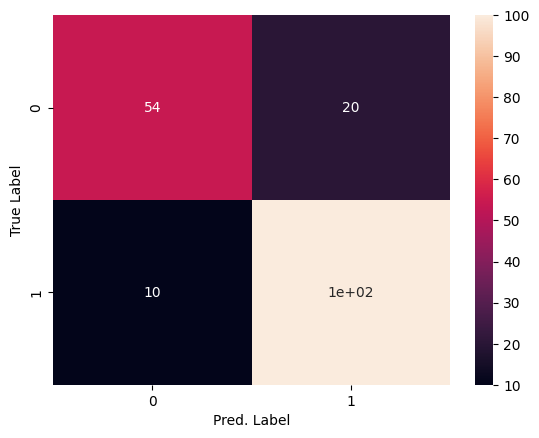

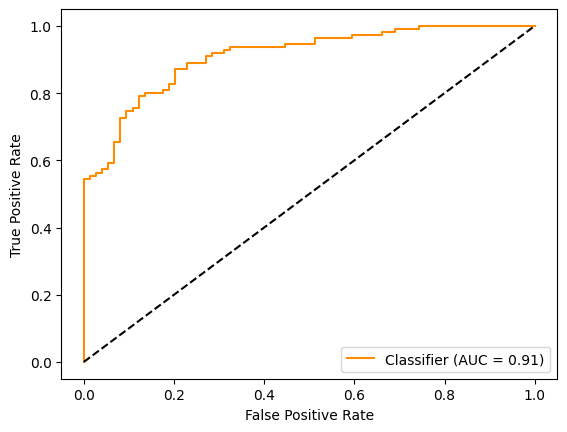

In [78]:
# get predictions
y_pred_prob = model(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
y_pred = np.round(y_pred_prob)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")